<a href="https://colab.research.google.com/github/farrelrassya/teachingMLDL/blob/main/02.%20Deep%20Learning/01.%20Week%201/Notebooks/05.activation_functions_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activation Functions Deep Dive

## Understanding the Non-Linear Heart of Neural Networks

---

**Course**: Deep Learning  
**Topic**: Activation Functions - From Sigmoid to Modern Activations  

---

### Learning Objectives

By the end of this notebook, you will:

1. **Understand** why activation functions are essential for neural networks
2. **Visualize** and **explain** the vanishing and exploding gradient problems
3. **Master** the ReLU family (Leaky ReLU, ELU, GELU, Swish)
4. **Know** when to use which activation function in practice
5. **Analyze** initialization strategies that prevent gradient issues

---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, LightSource
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Dark theme configuration
plt.style.use('default')
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#1a1a2e'
plt.rcParams['axes.edgecolor'] = '#ffffff'
plt.rcParams['axes.labelcolor'] = '#ffffff'
plt.rcParams['text.color'] = '#ffffff'
plt.rcParams['xtick.color'] = '#ffffff'
plt.rcParams['ytick.color'] = '#ffffff'
plt.rcParams['grid.color'] = '#333333'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Color palette
COLORS = {
    'sigmoid': '#FF6B6B',
    'tanh': '#4ECDC4',
    'relu': '#45B7D1',
    'leaky_relu': '#96CEB4',
    'elu': '#FFEAA7',
    'gelu': '#DDA0DD',
    'swish': '#FF69B4',
    'gradient': '#FFA500',
    'vanishing': '#3498db',
    'exploding': '#e74c3c',
}

print("Setup complete!")

Setup complete!


---

## Part 1: Why Do We Need Activation Functions?

### The Problem Without Activation Functions

Consider a neural network with **no activation functions**. Each layer performs:

$$\mathbf{h} = \mathbf{W} \cdot \mathbf{x} + \mathbf{b}$$

If we stack multiple layers:

$$\mathbf{h}_1 = \mathbf{W}_1 \cdot \mathbf{x} + \mathbf{b}_1$$
$$\mathbf{h}_2 = \mathbf{W}_2 \cdot \mathbf{h}_1 + \mathbf{b}_2$$

Substituting:

$$\mathbf{h}_2 = \mathbf{W}_2 \cdot (\mathbf{W}_1 \cdot \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \cdot \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2)$$

This is just **another linear transformation**! No matter how many layers we stack, we can only learn linear relationships.

### Key Insight

> **Activation functions introduce non-linearity**, allowing neural networks to learn complex patterns that linear models cannot capture.

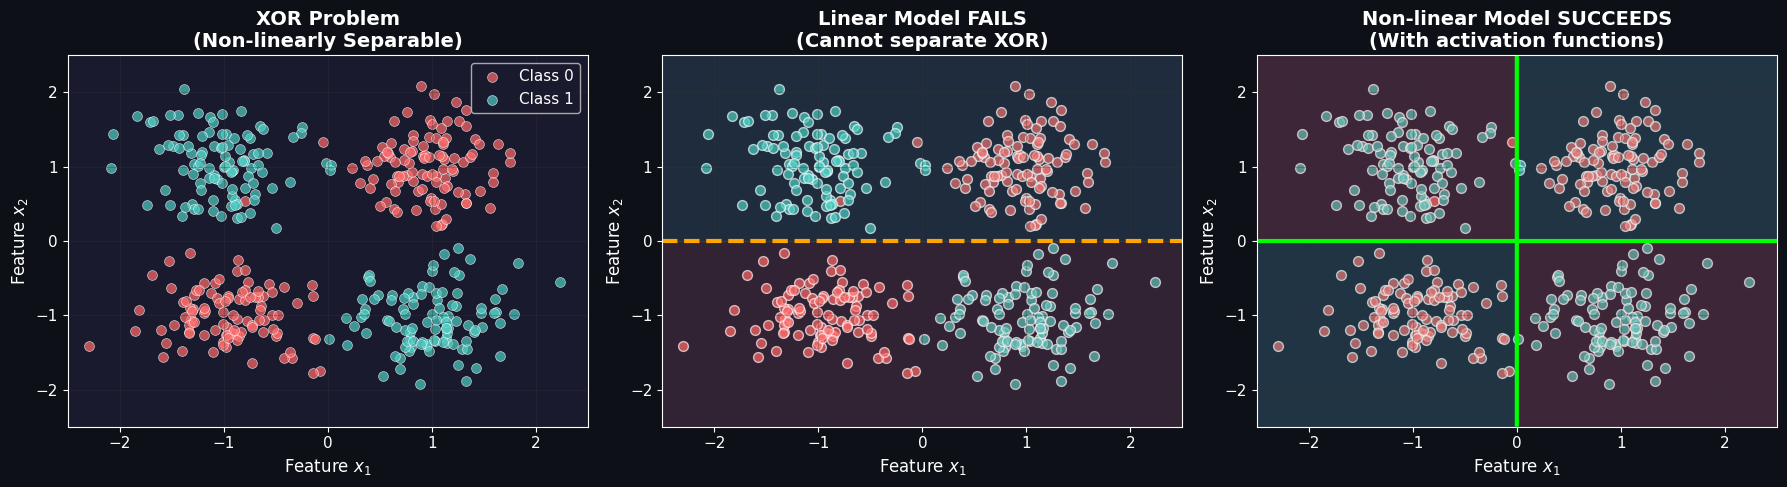


KEY INSIGHT: Without activation functions, neural networks can only learn linear boundaries!


In [ ]:
# Visualization: Linear vs Non-linear Decision Boundaries
np.random.seed(42)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('#0d1117')

# Generate XOR-like data (non-linearly separable)
n_points = 100
X1 = np.random.randn(n_points, 2) * 0.4 + np.array([1, 1])
X2 = np.random.randn(n_points, 2) * 0.4 + np.array([-1, -1])
X3 = np.random.randn(n_points, 2) * 0.4 + np.array([1, -1])
X4 = np.random.randn(n_points, 2) * 0.4 + np.array([-1, 1])

class_0 = np.vstack([X1, X2])
class_1 = np.vstack([X3, X4])

# Plot 1: The XOR problem
axes[0].scatter(class_0[:, 0], class_0[:, 1], c='#FF6B6B', s=50, alpha=0.7,
                label='Class 0', edgecolors='white', linewidth=0.5)
axes[0].scatter(class_1[:, 0], class_1[:, 1], c='#4ECDC4', s=50, alpha=0.7,
                label='Class 1', edgecolors='white', linewidth=0.5)
axes[0].set_title('XOR Problem\n(Non-linearly Separable)', fontweight='bold')
axes[0].set_xlabel('Feature $x_1$')
axes[0].set_ylabel('Feature $x_2$')
axes[0].legend(loc='upper right')
axes[0].set_xlim(-2.5, 2.5)
axes[0].set_ylim(-2.5, 2.5)

# Plot 2: Linear model fails
axes[1].scatter(class_0[:, 0], class_0[:, 1], c='#FF6B6B', s=50, alpha=0.7, edgecolors='white')
axes[1].scatter(class_1[:, 0], class_1[:, 1], c='#4ECDC4', s=50, alpha=0.7, edgecolors='white')
x_line = np.linspace(-2.5, 2.5, 100)
axes[1].plot(x_line, x_line * 0, '--', color='#FFA500', linewidth=3, label='Linear Boundary')
axes[1].fill_between(x_line, x_line * 0, 3, alpha=0.1, color='#4ECDC4')
axes[1].fill_between(x_line, -3, x_line * 0, alpha=0.1, color='#FF6B6B')
axes[1].set_title('Linear Model FAILS\n(Cannot separate XOR)', fontweight='bold')
axes[1].set_xlabel('Feature $x_1$')
axes[1].set_ylabel('Feature $x_2$')
axes[1].set_xlim(-2.5, 2.5)
axes[1].set_ylim(-2.5, 2.5)

# Plot 3: Non-linear model succeeds
axes[2].scatter(class_0[:, 0], class_0[:, 1], c='#FF6B6B', s=50, alpha=0.7, edgecolors='white')
axes[2].scatter(class_1[:, 0], class_1[:, 1], c='#4ECDC4', s=50, alpha=0.7, edgecolors='white')
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 200), np.linspace(-2.5, 2.5, 200))
Z = xx * yy
axes[2].contour(xx, yy, Z, levels=[0], colors=['#00FF00'], linewidths=3)
axes[2].contourf(xx, yy, Z, levels=[-10, 0], alpha=0.15, colors=['#FF6B6B'])
axes[2].contourf(xx, yy, Z, levels=[0, 10], alpha=0.15, colors=['#4ECDC4'])
axes[2].set_title('Non-linear Model SUCCEEDS\n(With activation functions)', fontweight='bold')
axes[2].set_xlabel('Feature $x_1$')
axes[2].set_ylabel('Feature $x_2$')
axes[2].set_xlim(-2.5, 2.5)
axes[2].set_ylim(-2.5, 2.5)

plt.tight_layout()
plt.show()

print("\nKEY INSIGHT: Without activation functions, neural networks can only learn linear boundaries!")

---

## Part 2: Classical Activation Functions - Sigmoid & Tanh

### 2.1 Sigmoid Function

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Properties:**
- Output range: $(0, 1)$
- Smooth and differentiable everywhere
- Derivative: $\sigma'(x) = \sigma(x)(1 - \sigma(x))$
- Maximum derivative: **0.25** (at x=0)

### 2.2 Tanh Function

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = 2\sigma(2x) - 1$$

**Properties:**
- Output range: $(-1, 1)$ - **Zero-centered!**
- Smooth and differentiable everywhere
- Derivative: $\tanh'(x) = 1 - \tanh^2(x)$
- Maximum derivative: **1.0** (at x=0)

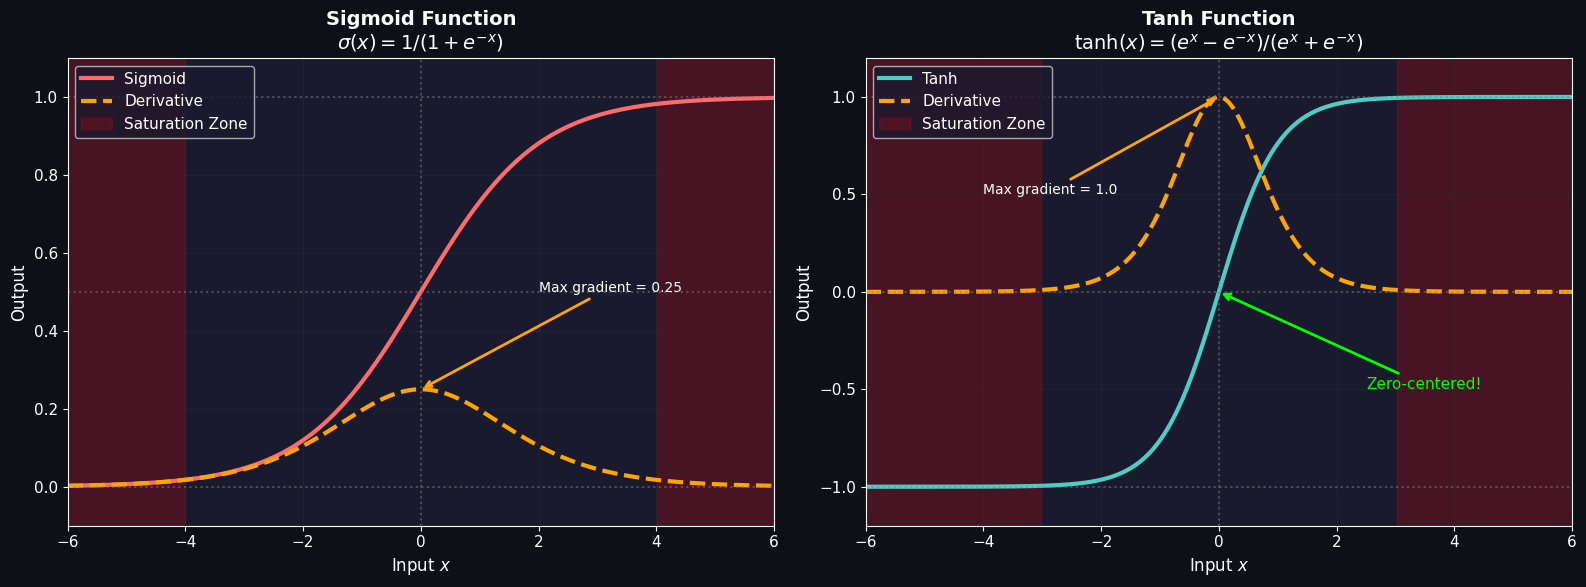


KEY OBSERVATIONS:
   - Sigmoid: Output in (0,1), NOT zero-centered
   - Tanh: Output in (-1,1), zero-centered (better)
   - Both: Gradients VANISH in saturation regions (red zones)!


In [ ]:
# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

# Create visualization
x = np.linspace(-6, 6, 500)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#0d1117')

# Plot Sigmoid
ax1 = axes[0]
ax1.plot(x, sigmoid(x), color=COLORS['sigmoid'], linewidth=3, label='Sigmoid')
ax1.plot(x, sigmoid_derivative(x), color=COLORS['gradient'], linewidth=3,
         linestyle='--', label='Derivative')
ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.fill_between(x[x < -4], -0.1, 1.1, alpha=0.2, color='red', label='Saturation Zone')
ax1.fill_between(x[x > 4], -0.1, 1.1, alpha=0.2, color='red')
ax1.annotate('Max gradient = 0.25', xy=(0, 0.25), xytext=(2, 0.5),
            fontsize=10, color='white',
            arrowprops=dict(arrowstyle='->', color=COLORS['gradient'], lw=2))
ax1.set_title('Sigmoid Function\n$\\sigma(x) = 1/(1 + e^{-x})$', fontweight='bold')
ax1.set_xlabel('Input $x$')
ax1.set_ylabel('Output')
ax1.legend(loc='upper left')
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlim(-6, 6)

# Plot Tanh
ax2 = axes[1]
ax2.plot(x, tanh(x), color=COLORS['tanh'], linewidth=3, label='Tanh')
ax2.plot(x, tanh_derivative(x), color=COLORS['gradient'], linewidth=3,
         linestyle='--', label='Derivative')
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(y=1, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(y=-1, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax2.fill_between(x[x < -3], -1.2, 1.2, alpha=0.2, color='red', label='Saturation Zone')
ax2.fill_between(x[x > 3], -1.2, 1.2, alpha=0.2, color='red')
ax2.annotate('Zero-centered!', xy=(0, 0), xytext=(2.5, -0.5),
            fontsize=11, color='#00FF00',
            arrowprops=dict(arrowstyle='->', color='#00FF00', lw=2))
ax2.annotate('Max gradient = 1.0', xy=(0, 1), xytext=(-4, 0.5),
            fontsize=10, color='white',
            arrowprops=dict(arrowstyle='->', color=COLORS['gradient'], lw=2))
ax2.set_title('Tanh Function\n$\\tanh(x) = (e^x - e^{-x})/(e^x + e^{-x})$', fontweight='bold')
ax2.set_xlabel('Input $x$')
ax2.set_ylabel('Output')
ax2.legend(loc='upper left')
ax2.set_ylim(-1.2, 1.2)
ax2.set_xlim(-6, 6)

plt.tight_layout()
plt.show()

print("\nKEY OBSERVATIONS:")
print("   - Sigmoid: Output in (0,1), NOT zero-centered")
print("   - Tanh: Output in (-1,1), zero-centered (better)")
print("   - Both: Gradients VANISH in saturation regions (red zones)!")

---

## Part 3: The Gradient Flow Problem

### Understanding Backpropagation and the Chain Rule

During **backpropagation**, gradients flow backward through the network using the **chain rule**:

$$\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial h_n} \cdot \frac{\partial h_n}{\partial h_{n-1}} \cdot \ldots \cdot \frac{\partial h_2}{\partial h_1} \cdot \frac{\partial h_1}{\partial W_1}$$

Each term $\frac{\partial h_i}{\partial h_{i-1}}$ involves:
- The **weight matrix** $W_i$
- The **derivative of the activation function** $\sigma'$

### Two Critical Problems

| Problem | Cause | Effect | Symptom |
|---------|-------|--------|--------|
| **Vanishing Gradients** | Derivatives < 1 multiplied many times | Gradients shrink exponentially | Early layers don't learn |
| **Exploding Gradients** | Derivatives > 1 or large weights multiplied many times | Gradients grow exponentially | Training becomes unstable, NaN losses |

---

## Part 3.1: Vanishing Gradients - The Silent Killer

### Intuitive Understanding

Imagine you're playing **telephone** (the game where you whisper a message through a chain of people):

- If each person speaks at **50% volume**, after 10 people the message is at $0.5^{10} = 0.001$ (0.1%) of the original
- The message becomes inaudible!

This is exactly what happens with gradients:
- Sigmoid's max derivative is **0.25**
- After 10 layers: $0.25^{10} \approx 0.00000095$ (essentially zero!)

### Why It Matters

- Early layers receive tiny gradients
- They learn **extremely slowly** or not at all
- The network becomes effectively "shallow"

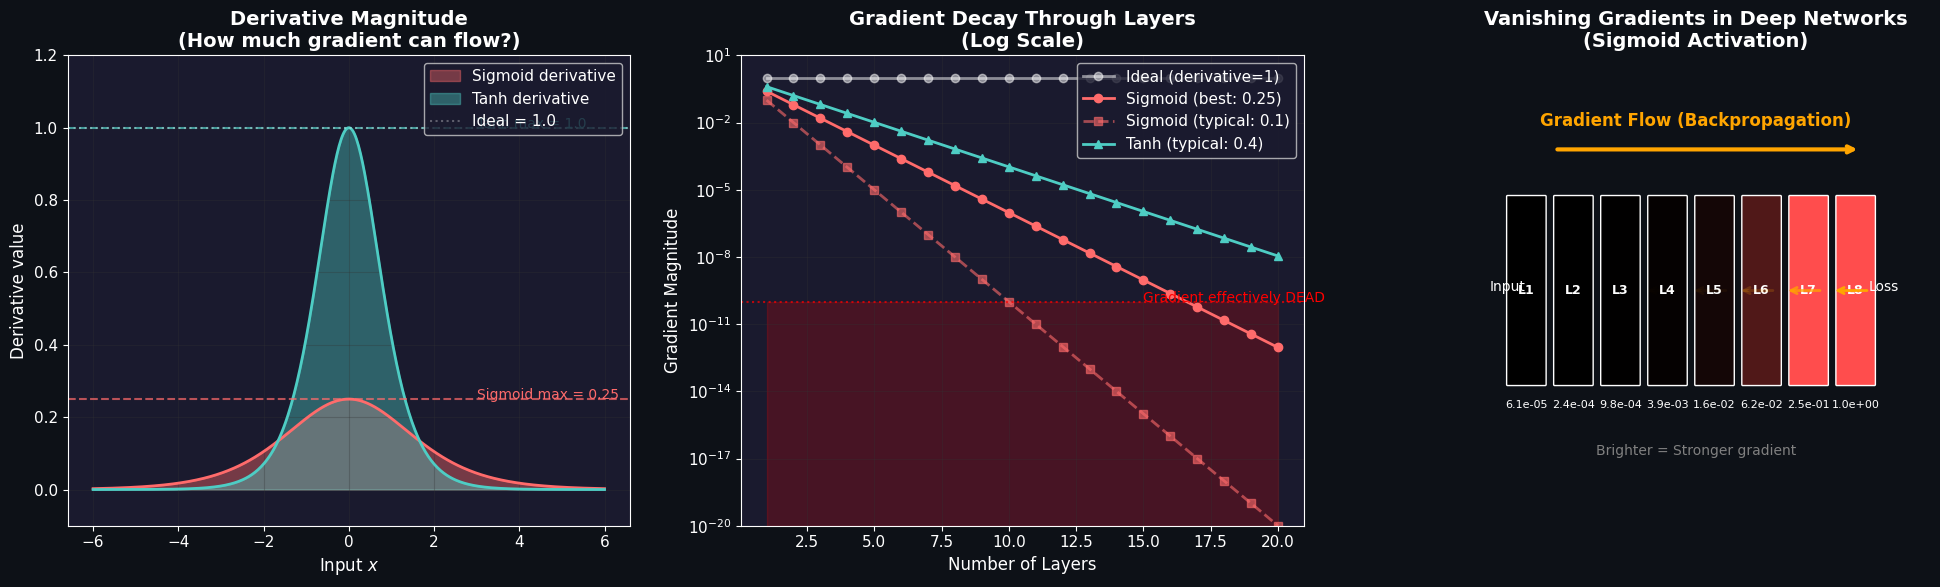


VANISHING GRADIENT PROBLEM:
   - Sigmoid: After 10 layers, gradient = 0.25^10 = 0.00000095
   - Early layers learn EXTREMELY slowly (or not at all!)
   - This limited deep learning progress for decades!


In [ ]:
# Visualization: Vanishing Gradient Problem

def visualize_vanishing_gradient():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.patch.set_facecolor('#0d1117')

    # Plot 1: Derivative magnitude across input range
    ax1 = axes[0]
    x = np.linspace(-6, 6, 500)

    ax1.fill_between(x, sigmoid_derivative(x), alpha=0.4, color=COLORS['sigmoid'],
                     label='Sigmoid derivative')
    ax1.fill_between(x, tanh_derivative(x), alpha=0.4, color=COLORS['tanh'],
                     label='Tanh derivative')
    ax1.plot(x, sigmoid_derivative(x), color=COLORS['sigmoid'], linewidth=2)
    ax1.plot(x, tanh_derivative(x), color=COLORS['tanh'], linewidth=2)
    ax1.axhline(y=0.25, color=COLORS['sigmoid'], linestyle='--', alpha=0.7)
    ax1.axhline(y=1.0, color=COLORS['tanh'], linestyle='--', alpha=0.7)
    ax1.axhline(y=1.0, color='white', linestyle=':', alpha=0.3, label='Ideal = 1.0')

    ax1.annotate('Sigmoid max = 0.25', xy=(3, 0.25), fontsize=10, color=COLORS['sigmoid'])
    ax1.annotate('Tanh max = 1.0', xy=(3, 1.0), fontsize=10, color=COLORS['tanh'])

    ax1.set_title('Derivative Magnitude\n(How much gradient can flow?)', fontweight='bold')
    ax1.set_xlabel('Input $x$')
    ax1.set_ylabel('Derivative value')
    ax1.legend(loc='upper right')
    ax1.set_ylim(-0.1, 1.2)

    # Plot 2: Gradient decay through layers
    ax2 = axes[1]
    layers = np.arange(1, 21)

    sigmoid_best = 0.25 ** layers
    sigmoid_typical = 0.1 ** layers
    tanh_typical = 0.4 ** layers
    ideal = 1.0 ** layers

    ax2.semilogy(layers, ideal, 'o-', color='white', linewidth=2,
                 markersize=6, label='Ideal (derivative=1)', alpha=0.5)
    ax2.semilogy(layers, sigmoid_best, 'o-', color=COLORS['sigmoid'], linewidth=2,
                 markersize=6, label='Sigmoid (best: 0.25)')
    ax2.semilogy(layers, sigmoid_typical, 's--', color=COLORS['sigmoid'], linewidth=2,
                 markersize=6, alpha=0.6, label='Sigmoid (typical: 0.1)')
    ax2.semilogy(layers, tanh_typical, '^-', color=COLORS['tanh'], linewidth=2,
                 markersize=6, label='Tanh (typical: 0.4)')

    ax2.axhline(y=1e-10, color='red', linestyle=':', alpha=0.7)
    ax2.annotate('Gradient effectively DEAD', xy=(15, 1e-10), fontsize=10, color='red')
    ax2.fill_between(layers, 1e-20, 1e-10, alpha=0.2, color='red')

    ax2.set_title('Gradient Decay Through Layers\n(Log Scale)', fontweight='bold')
    ax2.set_xlabel('Number of Layers')
    ax2.set_ylabel('Gradient Magnitude')
    ax2.legend(loc='upper right')
    ax2.set_ylim(1e-20, 10)

    # Plot 3: Network diagram showing gradient flow
    ax3 = axes[2]
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)

    # Draw layers as boxes with gradient colors
    n_layers = 8
    layer_width = 0.8

    for i in range(n_layers):
        pos = i + 1
        gradient_strength = 0.25 ** (n_layers - 1 - i)
        color_intensity = min(1, gradient_strength * 5)
        box_color = (color_intensity, color_intensity * 0.3, color_intensity * 0.3)

        rect = mpatches.FancyBboxPatch((pos, 3), layer_width, 4,
                                        boxstyle="round,pad=0.02",
                                        facecolor=box_color, edgecolor='white',
                                        linewidth=1)
        ax3.add_patch(rect)
        ax3.text(pos + layer_width/2, 5, f'L{i+1}', ha='center', va='center',
                fontsize=9, color='white', fontweight='bold')
        ax3.text(pos + layer_width/2, 2.5, f'{gradient_strength:.1e}', ha='center',
                fontsize=8, color='white')

    # Draw gradient flow arrows
    for i in range(n_layers - 1, 0, -1):
        pos = i + 1
        arrow_alpha = 0.25 ** (n_layers - 1 - i) * 3
        ax3.annotate('', xy=(pos - 0.1, 5), xytext=(pos + 0.7, 5),
                    arrowprops=dict(arrowstyle='->', color=COLORS['gradient'],
                                   lw=2, alpha=min(1, arrow_alpha)))

    ax3.text(5, 8.5, 'Gradient Flow (Backpropagation)', ha='center', fontsize=12,
            color=COLORS['gradient'], fontweight='bold')
    ax3.annotate('', xy=(2, 8), xytext=(8.5, 8),
                arrowprops=dict(arrowstyle='<-', color=COLORS['gradient'], lw=3))
    ax3.text(9, 5, 'Loss', ha='center', fontsize=10, color='white')
    ax3.text(1, 5, 'Input', ha='center', fontsize=10, color='white')
    ax3.text(5, 1.5, 'Brighter = Stronger gradient', ha='center', fontsize=10, color='gray')

    ax3.set_title('Vanishing Gradients in Deep Networks\n(Sigmoid Activation)', fontweight='bold')
    ax3.set_aspect('equal')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

visualize_vanishing_gradient()

print("\nVANISHING GRADIENT PROBLEM:")
print("   - Sigmoid: After 10 layers, gradient = 0.25^10 = 0.00000095")
print("   - Early layers learn EXTREMELY slowly (or not at all!)")
print("   - This limited deep learning progress for decades!")

---

## Part 3.2: Exploding Gradients - The Unstable Beast

### Intuitive Understanding

Now imagine the opposite scenario in our **telephone game**:

- If each person **shouts 2x louder** than they heard, after 10 people the volume is $2^{10} = 1024$ times the original
- The message becomes **deafening and distorted**!

This happens when:
- Weights are initialized too large
- The product of weights and derivatives > 1

### Symptoms of Exploding Gradients

1. **Loss becomes NaN** (Not a Number)
2. **Loss oscillates wildly** or increases
3. **Weights become very large** (overflow)
4. **Training is unstable** and fails to converge

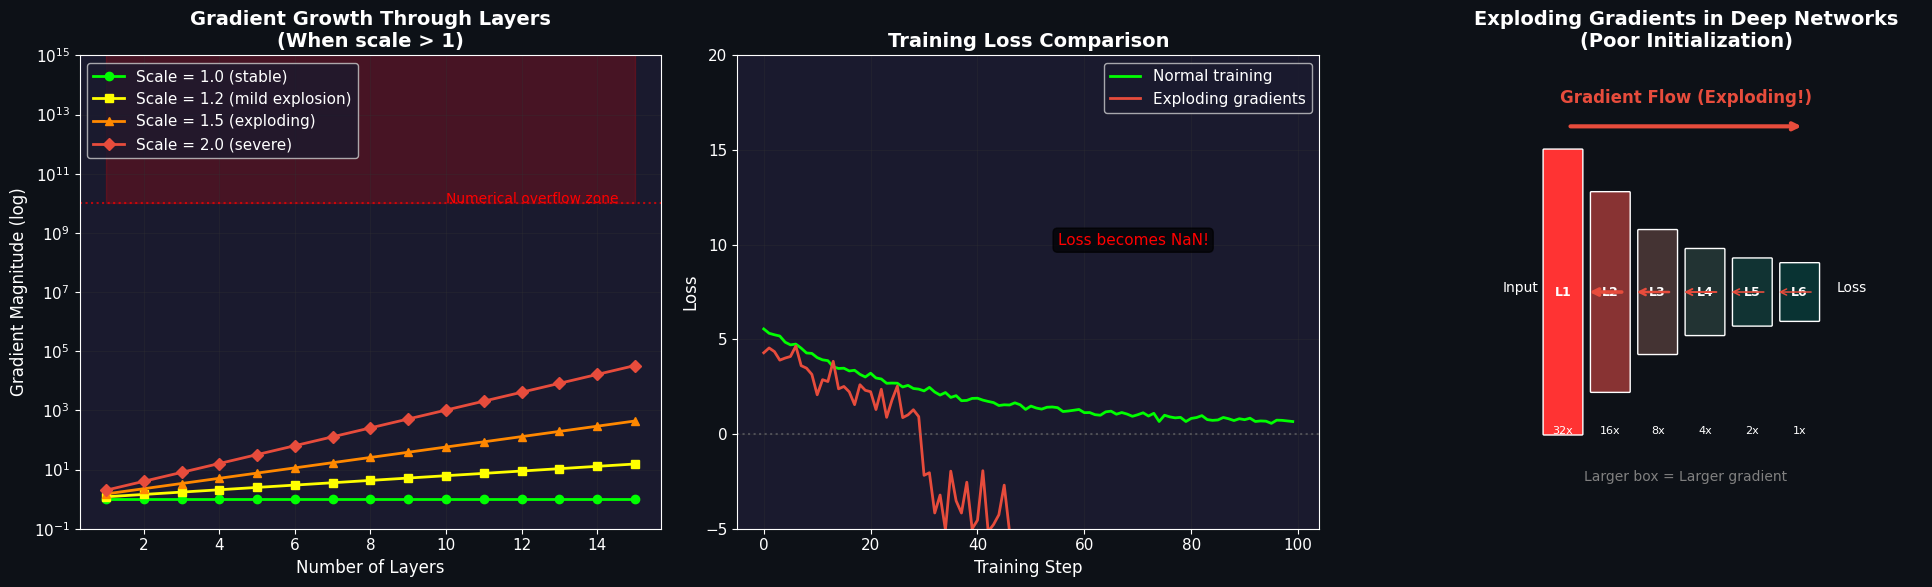


EXPLODING GRADIENT PROBLEM:
   - If weight scale > 1: gradients grow exponentially
   - 2.0^15 = 32,768x amplification in just 15 layers!
   - Causes: NaN loss, unstable training, numerical overflow


In [ ]:
# Visualization: Exploding Gradient Problem

def visualize_exploding_gradient():
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.patch.set_facecolor('#0d1117')

    # Plot 1: Gradient growth through layers
    ax1 = axes[0]
    layers = np.arange(1, 16)

    # Different weight scales
    scale_stable = 1.0 ** layers
    scale_mild = 1.2 ** layers
    scale_bad = 1.5 ** layers
    scale_worse = 2.0 ** layers

    ax1.semilogy(layers, scale_stable, 'o-', color='#00ff00', linewidth=2,
                 markersize=6, label='Scale = 1.0 (stable)')
    ax1.semilogy(layers, scale_mild, 's-', color='#ffff00', linewidth=2,
                 markersize=6, label='Scale = 1.2 (mild explosion)')
    ax1.semilogy(layers, scale_bad, '^-', color='#ff8800', linewidth=2,
                 markersize=6, label='Scale = 1.5 (exploding)')
    ax1.semilogy(layers, scale_worse, 'D-', color=COLORS['exploding'], linewidth=2,
                 markersize=6, label='Scale = 2.0 (severe)')

    ax1.axhline(y=1e10, color='red', linestyle=':', alpha=0.7)
    ax1.annotate('Numerical overflow zone', xy=(10, 1e10), fontsize=10, color='red')
    ax1.fill_between(layers, 1e10, 1e20, alpha=0.2, color='red')

    ax1.set_title('Gradient Growth Through Layers\n(When scale > 1)', fontweight='bold')
    ax1.set_xlabel('Number of Layers')
    ax1.set_ylabel('Gradient Magnitude (log)')
    ax1.legend(loc='upper left')
    ax1.set_ylim(0.1, 1e15)

    # Plot 2: Training loss comparison
    ax2 = axes[1]
    steps = np.arange(0, 100)

    np.random.seed(42)
    # Normal training
    loss_normal = 5 * np.exp(-steps / 30) + 0.5 + np.random.randn(100) * 0.1

    # Exploding gradients
    loss_exploding = np.zeros(100)
    loss_exploding[:30] = 5 * np.exp(-steps[:30] / 20) + np.random.randn(30) * 0.5
    loss_exploding[30:50] = loss_exploding[29] + np.cumsum(np.random.randn(20) * 2)
    loss_exploding[50:] = np.nan  # NaN after explosion

    ax2.plot(steps, loss_normal, color='#00ff00', linewidth=2, label='Normal training')
    ax2.plot(steps, loss_exploding, color=COLORS['exploding'], linewidth=2,
             label='Exploding gradients')

    ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax2.annotate('Loss becomes NaN!', xy=(55, 10), fontsize=11, color='red',
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))

    ax2.set_title('Training Loss Comparison', fontweight='bold')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylim(-5, 20)

    # Plot 3: Network diagram showing explosion
    ax3 = axes[2]
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)

    n_layers = 6
    layer_width = 0.8

    for i in range(n_layers):
        pos = i + 2
        gradient_strength = 2.0 ** (n_layers - 1 - i)

        # Color based on gradient magnitude (red = exploding)
        red = min(1, gradient_strength / 30)
        height = min(6, 1 + gradient_strength / 5)  # Box grows with gradient

        rect = mpatches.FancyBboxPatch((pos, 5 - height/2), layer_width, height,
                                        boxstyle="round,pad=0.02",
                                        facecolor=(red, 0.2, 0.2),
                                        edgecolor='white', linewidth=1)
        ax3.add_patch(rect)
        ax3.text(pos + layer_width/2, 5, f'L{i+1}', ha='center', va='center',
                fontsize=9, color='white', fontweight='bold')
        if gradient_strength < 1000:
            ax3.text(pos + layer_width/2, 2, f'{gradient_strength:.0f}x', ha='center',
                    fontsize=8, color='white')
        else:
            ax3.text(pos + layer_width/2, 2, 'HUGE!', ha='center',
                    fontsize=8, color='red', fontweight='bold')

    # Gradient flow arrows (getting bigger)
    for i in range(n_layers - 1, 0, -1):
        pos = i + 2
        arrow_size = min(4, 1 + 2.0 ** (n_layers - 1 - i) / 10)
        ax3.annotate('', xy=(pos - 0.1, 5), xytext=(pos + 0.7, 5),
                    arrowprops=dict(arrowstyle='->', color=COLORS['exploding'],
                                   lw=arrow_size))

    ax3.text(5, 9, 'Gradient Flow (Exploding!)', ha='center', fontsize=12,
            color=COLORS['exploding'], fontweight='bold')
    ax3.annotate('', xy=(2.5, 8.5), xytext=(7.5, 8.5),
                arrowprops=dict(arrowstyle='<-', color=COLORS['exploding'], lw=3))
    ax3.text(8.5, 5, 'Loss', ha='center', fontsize=10, color='white')
    ax3.text(1.5, 5, 'Input', ha='center', fontsize=10, color='white')
    ax3.text(5, 1, 'Larger box = Larger gradient', ha='center', fontsize=10, color='gray')

    ax3.set_title('Exploding Gradients in Deep Networks\n(Poor Initialization)', fontweight='bold')
    ax3.set_aspect('equal')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

visualize_exploding_gradient()

print("\nEXPLODING GRADIENT PROBLEM:")
print("   - If weight scale > 1: gradients grow exponentially")
print("   - 2.0^15 = 32,768x amplification in just 15 layers!")
print("   - Causes: NaN loss, unstable training, numerical overflow")

---

## Part 3.3: Visualizing Both Problems Together

The key insight is that we need gradients to stay **close to 1** as they flow backward.

- **< 1**: Vanishing (shrinking exponentially)
- **= 1**: Perfect (stable gradient flow)
- **> 1**: Exploding (growing exponentially)

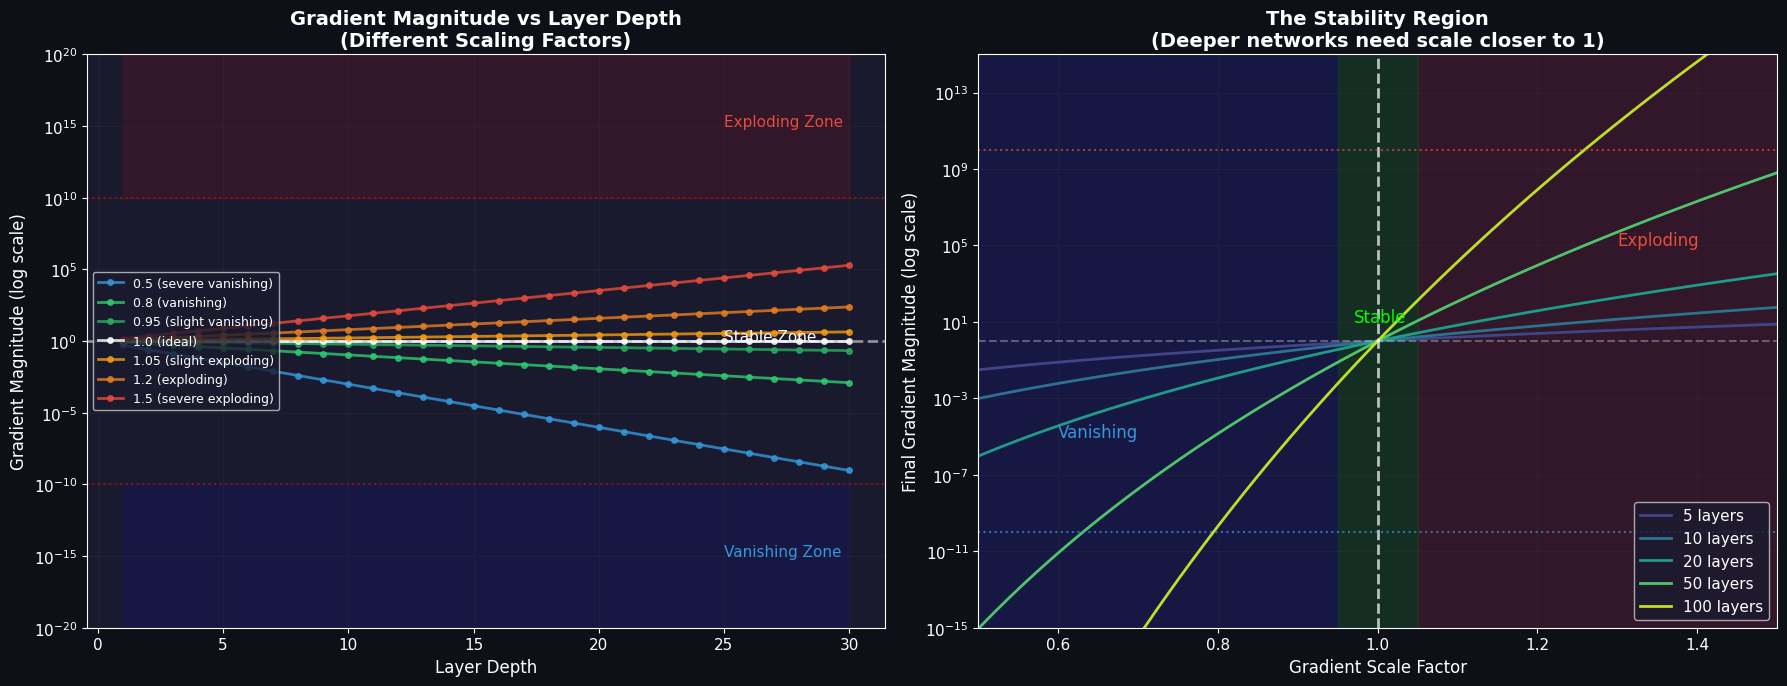


KEY INSIGHT:
   - Deeper networks are MORE sensitive to scaling
   - Even scale = 0.95 causes vanishing in 100-layer networks
   - We need techniques to keep gradients stable!


In [ ]:
# Combined visualization: Vanishing vs Exploding

def simulate_gradient_flow_scenarios():
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    fig.patch.set_facecolor('#0d1117')

    layers = np.arange(1, 31)

    # Left plot: Different scaling factors
    ax1 = axes[0]

    scales = [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
    colors = ['#3498db', '#2ecc71', '#27ae60', '#ffffff', '#f39c12', '#e67e22', '#e74c3c']
    labels = ['0.5 (severe vanishing)', '0.8 (vanishing)', '0.95 (slight vanishing)',
              '1.0 (ideal)', '1.05 (slight exploding)', '1.2 (exploding)', '1.5 (severe exploding)']

    for scale, color, label in zip(scales, colors, labels):
        gradient = scale ** layers
        ax1.semilogy(layers, gradient, 'o-', color=color, linewidth=2,
                     markersize=4, label=label, alpha=0.8)

    ax1.axhline(y=1, color='white', linestyle='--', alpha=0.5, linewidth=2)
    ax1.axhline(y=1e-10, color='red', linestyle=':', alpha=0.5)
    ax1.axhline(y=1e10, color='red', linestyle=':', alpha=0.5)

    ax1.fill_between(layers, 1e-20, 1e-10, alpha=0.1, color='blue', label='_nolegend_')
    ax1.fill_between(layers, 1e10, 1e20, alpha=0.1, color='red', label='_nolegend_')

    ax1.annotate('Vanishing Zone', xy=(25, 1e-15), fontsize=11, color=COLORS['vanishing'])
    ax1.annotate('Exploding Zone', xy=(25, 1e15), fontsize=11, color=COLORS['exploding'])
    ax1.annotate('Stable Zone', xy=(25, 1), fontsize=11, color='white')

    ax1.set_title('Gradient Magnitude vs Layer Depth\n(Different Scaling Factors)', fontweight='bold')
    ax1.set_xlabel('Layer Depth')
    ax1.set_ylabel('Gradient Magnitude (log scale)')
    ax1.legend(loc='center left', fontsize=9)
    ax1.set_ylim(1e-20, 1e20)

    # Right plot: Stability region
    ax2 = axes[1]

    scales = np.linspace(0.5, 1.5, 100)
    depths = [5, 10, 20, 50, 100]
    colors_depth = plt.cm.viridis(np.linspace(0.2, 0.9, len(depths)))

    for depth, color in zip(depths, colors_depth):
        gradients = scales ** depth
        ax2.semilogy(scales, gradients, linewidth=2, color=color, label=f'{depth} layers')

    ax2.axvline(x=1.0, color='white', linestyle='--', alpha=0.7, linewidth=2)
    ax2.axhline(y=1, color='white', linestyle='--', alpha=0.3)
    ax2.axhline(y=1e-10, color=COLORS['vanishing'], linestyle=':', alpha=0.7)
    ax2.axhline(y=1e10, color=COLORS['exploding'], linestyle=':', alpha=0.7)

    ax2.fill_betweenx([1e-20, 1e20], 0.5, 0.95, alpha=0.1, color='blue')
    ax2.fill_betweenx([1e-20, 1e20], 1.05, 1.5, alpha=0.1, color='red')
    ax2.fill_betweenx([1e-20, 1e20], 0.95, 1.05, alpha=0.2, color='green')

    ax2.annotate('Vanishing', xy=(0.6, 1e-5), fontsize=12, color=COLORS['vanishing'])
    ax2.annotate('Stable', xy=(0.97, 10), fontsize=12, color='#00ff00')
    ax2.annotate('Exploding', xy=(1.3, 1e5), fontsize=12, color=COLORS['exploding'])

    ax2.set_title('The Stability Region\n(Deeper networks need scale closer to 1)', fontweight='bold')
    ax2.set_xlabel('Gradient Scale Factor')
    ax2.set_ylabel('Final Gradient Magnitude (log scale)')
    ax2.legend(loc='lower right')
    ax2.set_xlim(0.5, 1.5)
    ax2.set_ylim(1e-15, 1e15)

    plt.tight_layout()
    plt.show()

simulate_gradient_flow_scenarios()

print("\nKEY INSIGHT:")
print("   - Deeper networks are MORE sensitive to scaling")
print("   - Even scale = 0.95 causes vanishing in 100-layer networks")
print("   - We need techniques to keep gradients stable!")

---

## Part 3.4: Solutions to Gradient Problems

### Solutions Overview

| Problem | Solution | How It Helps |
|---------|----------|-------------|
| Vanishing | **ReLU activation** | Derivative = 1 for positive inputs |
| Vanishing | **Residual connections** | Gradient can flow directly through skip connections |
| Vanishing | **Batch Normalization** | Keeps activations in good range |
| Exploding | **Gradient clipping** | Caps gradient magnitude |
| Exploding | **Proper initialization** | Xavier/He initialization |
| Both | **LSTM/GRU gates** | For RNNs, gates control gradient flow |

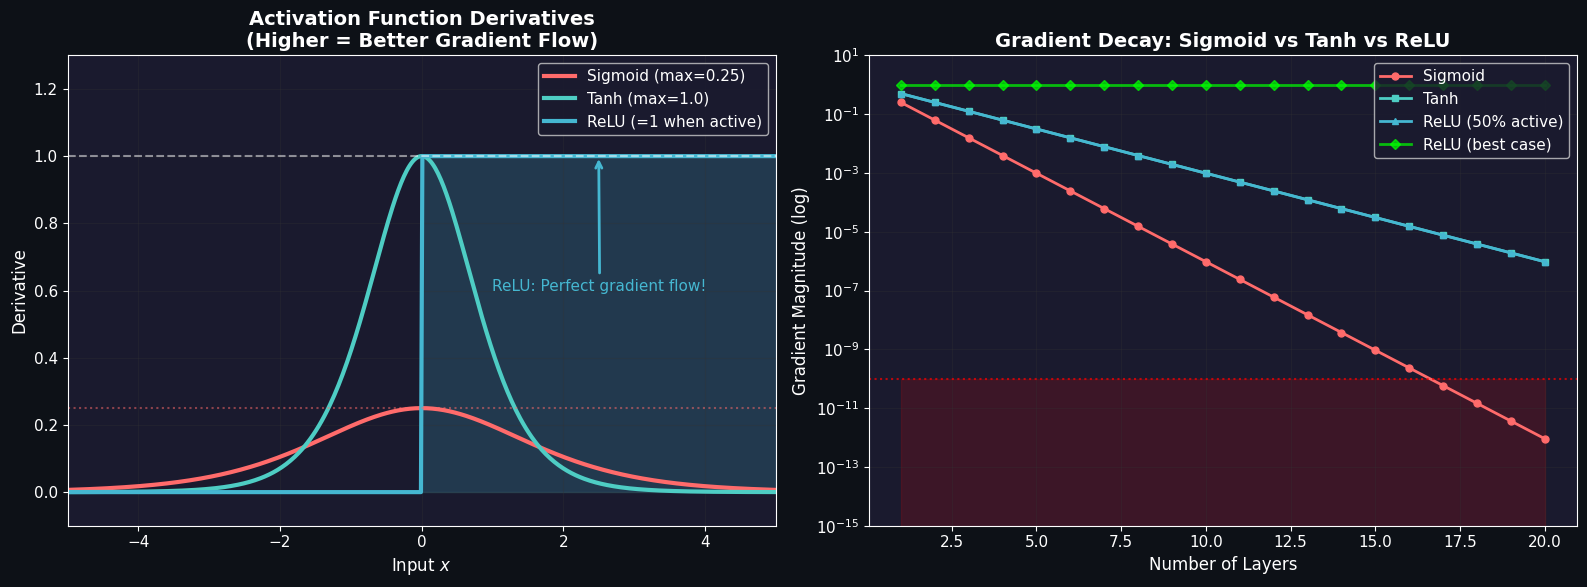


WHY ReLU REVOLUTIONIZED DEEP LEARNING:
   - Derivative = 1 for positive inputs (no shrinking!)
   - Gradients can flow unchanged through active neurons
   - Enabled training of much deeper networks


In [ ]:
# Visualization: How ReLU solves vanishing gradients

def compare_gradient_flow():
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.patch.set_facecolor('#0d1117')

    # Define ReLU
    def relu(x):
        return np.maximum(0, x)

    def relu_derivative(x):
        return (x > 0).astype(float)

    # Left: Derivative comparison
    ax1 = axes[0]
    x = np.linspace(-5, 5, 500)

    ax1.plot(x, sigmoid_derivative(x), color=COLORS['sigmoid'], linewidth=3,
             label='Sigmoid (max=0.25)')
    ax1.plot(x, tanh_derivative(x), color=COLORS['tanh'], linewidth=3,
             label='Tanh (max=1.0)')
    ax1.plot(x, relu_derivative(x), color=COLORS['relu'], linewidth=3,
             label='ReLU (=1 when active)')

    ax1.axhline(y=1, color='white', linestyle='--', alpha=0.5)
    ax1.axhline(y=0.25, color=COLORS['sigmoid'], linestyle=':', alpha=0.5)

    ax1.fill_between(x[x > 0], 0, relu_derivative(x[x > 0]), alpha=0.2, color=COLORS['relu'])

    ax1.annotate('ReLU: Perfect gradient flow!', xy=(2.5, 1), xytext=(1, 0.6),
                fontsize=11, color=COLORS['relu'],
                arrowprops=dict(arrowstyle='->', color=COLORS['relu'], lw=2))

    ax1.set_title('Activation Function Derivatives\n(Higher = Better Gradient Flow)', fontweight='bold')
    ax1.set_xlabel('Input $x$')
    ax1.set_ylabel('Derivative')
    ax1.legend(loc='upper right')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-0.1, 1.3)

    # Right: Gradient decay comparison
    ax2 = axes[1]
    layers = np.arange(1, 21)

    # Assume 50% of ReLU neurons are active (typical)
    sigmoid_decay = 0.25 ** layers
    tanh_decay = 0.5 ** layers  # Typical, not best case
    relu_decay = 0.5 ** layers * (1.0 ** layers)  # 50% active, derivative=1
    relu_best = 1.0 ** layers  # If all neurons active

    ax2.semilogy(layers, sigmoid_decay, 'o-', color=COLORS['sigmoid'], linewidth=2,
                 markersize=5, label='Sigmoid')
    ax2.semilogy(layers, tanh_decay, 's-', color=COLORS['tanh'], linewidth=2,
                 markersize=5, label='Tanh')
    ax2.semilogy(layers, relu_decay, '^-', color=COLORS['relu'], linewidth=2,
                 markersize=5, label='ReLU (50% active)')
    ax2.semilogy(layers, relu_best, 'D-', color='#00ff00', linewidth=2,
                 markersize=5, label='ReLU (best case)', alpha=0.7)

    ax2.axhline(y=1e-10, color='red', linestyle=':', alpha=0.7)
    ax2.fill_between(layers, 1e-20, 1e-10, alpha=0.15, color='red')

    ax2.set_title('Gradient Decay: Sigmoid vs Tanh vs ReLU', fontweight='bold')
    ax2.set_xlabel('Number of Layers')
    ax2.set_ylabel('Gradient Magnitude (log)')
    ax2.legend(loc='upper right')
    ax2.set_ylim(1e-15, 10)

    plt.tight_layout()
    plt.show()

compare_gradient_flow()

print("\nWHY ReLU REVOLUTIONIZED DEEP LEARNING:")
print("   - Derivative = 1 for positive inputs (no shrinking!)")
print("   - Gradients can flow unchanged through active neurons")
print("   - Enabled training of much deeper networks")

---

## Part 4: The ReLU Family

### 4.1 ReLU (Rectified Linear Unit)

$$\text{ReLU}(x) = \max(0, x)$$

**Derivative:** $1$ if $x > 0$, else $0$

### Why ReLU is Revolutionary

| Property | Sigmoid/Tanh | ReLU |
|----------|--------------|------|
| Max Gradient | 0.25 / 1.0 | **1.0** (always when active) |
| Computation | Expensive (exp) | **Cheap** (comparison) |
| Saturation | Both sides | **Only negative side** |
| Sparsity | No | **Yes** (~50% neurons inactive) |

In [ ]:
# Define ReLU family
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))

def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def gelu_derivative(x):
    h = 1e-7
    return (gelu(x + h) - gelu(x - h)) / (2 * h)

def swish(x, beta=1.0):
    return x * sigmoid(beta * x)

def swish_derivative(x, beta=1.0):
    sig = sigmoid(beta * x)
    return sig + beta * x * sig * (1 - sig)

print("ReLU family functions defined!")

ReLU family functions defined!


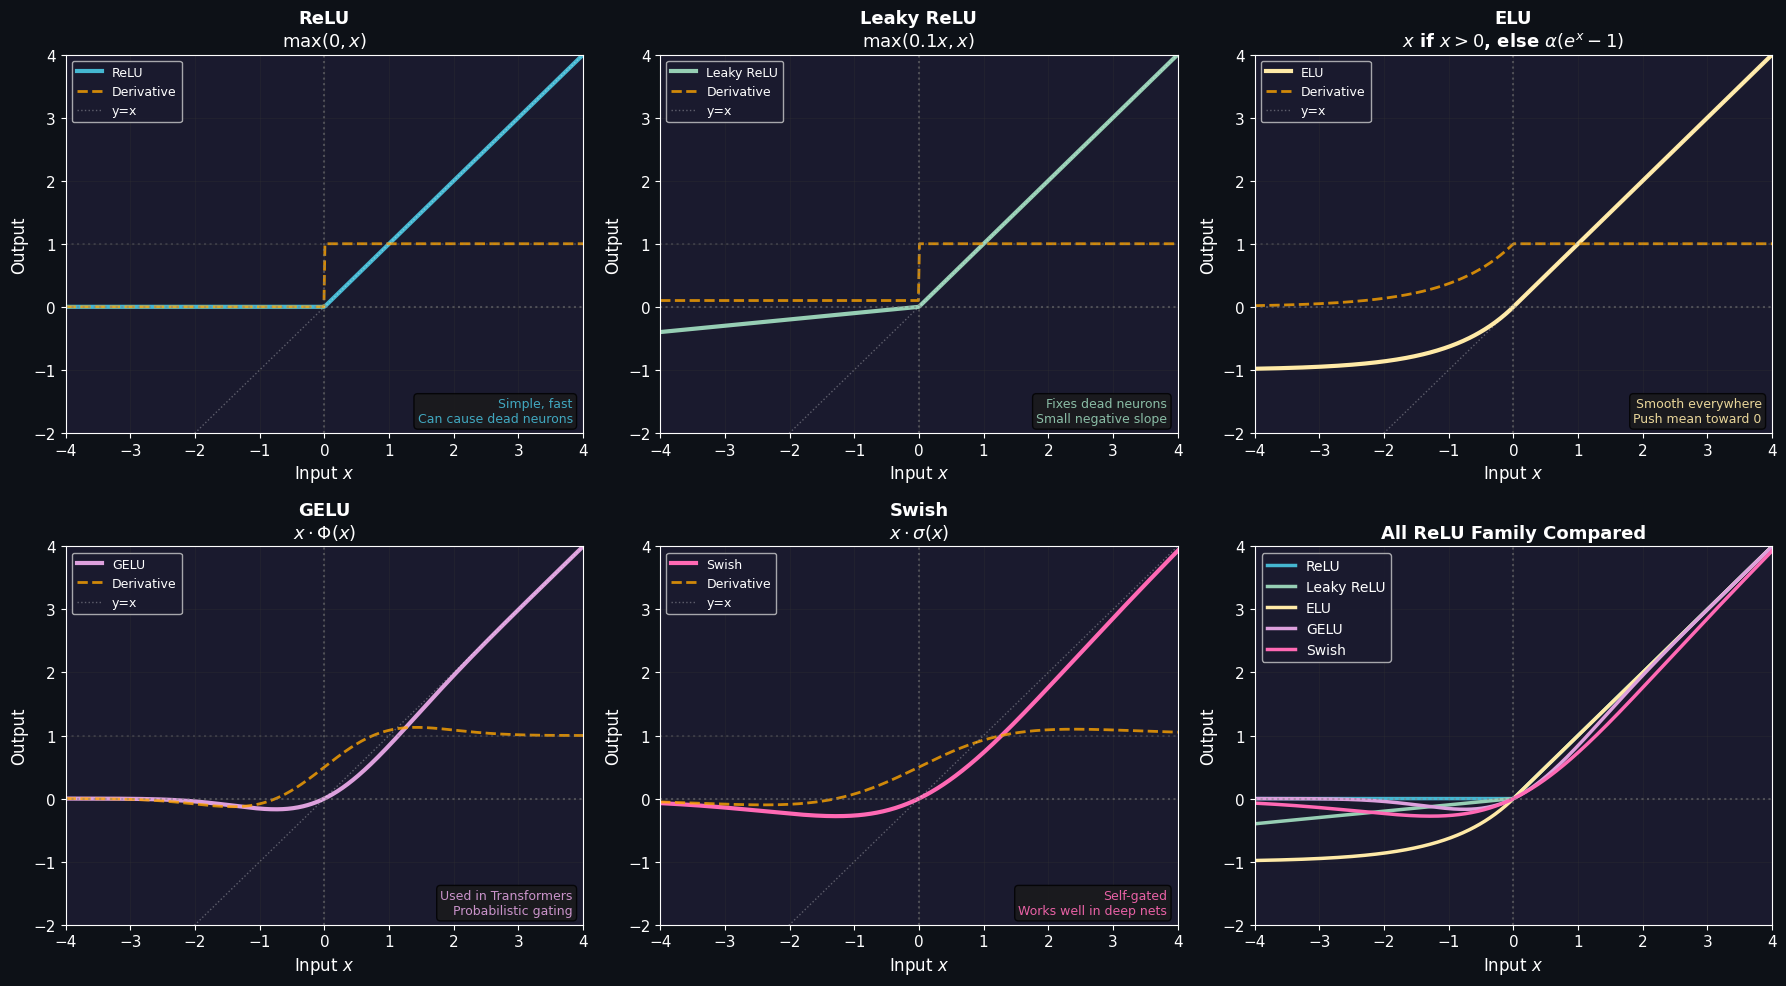

In [ ]:
# Comprehensive ReLU Family Visualization

x = np.linspace(-4, 4, 500)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.patch.set_facecolor('#0d1117')

activations = [
    ('ReLU', relu, relu_derivative, COLORS['relu'],
     r'$\max(0, x)$', 'Simple, fast\nCan cause dead neurons'),
    ('Leaky ReLU', lambda x: leaky_relu(x, 0.1), lambda x: leaky_relu_derivative(x, 0.1),
     COLORS['leaky_relu'], r'$\max(0.1x, x)$', 'Fixes dead neurons\nSmall negative slope'),
    ('ELU', elu, elu_derivative, COLORS['elu'],
     r'$x$ if $x>0$, else $\alpha(e^x-1)$', 'Smooth everywhere\nPush mean toward 0'),
    ('GELU', gelu, gelu_derivative, COLORS['gelu'],
     r'$x \cdot \Phi(x)$', 'Used in Transformers\nProbabilistic gating'),
    ('Swish', swish, swish_derivative, COLORS['swish'],
     r'$x \cdot \sigma(x)$', 'Self-gated\nWorks well in deep nets'),
]

axes_flat = axes.flatten()

for idx, (name, func, deriv, color, formula, notes) in enumerate(activations):
    ax = axes_flat[idx]

    y = func(x)
    dy = deriv(x)

    ax.plot(x, y, color=color, linewidth=3, label=f'{name}')
    ax.plot(x, dy, color=COLORS['gradient'], linewidth=2, linestyle='--',
            label='Derivative', alpha=0.8)

    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
    ax.axhline(y=1, color='gray', linestyle=':', alpha=0.3)
    ax.plot(x, x, color='white', linewidth=1, linestyle=':', alpha=0.3, label='y=x')

    ax.set_title(f'{name}\n{formula}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Input $x$')
    ax.set_ylabel('Output')
    ax.legend(loc='upper left', fontsize=9)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-2, 4)

    ax.text(0.98, 0.02, notes, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right',
            color=color, alpha=0.9,
            bbox=dict(boxstyle='round', facecolor='#1a1a1a', alpha=0.8))

# Comparison plot
ax = axes_flat[5]
ax.plot(x, relu(x), color=COLORS['relu'], linewidth=2.5, label='ReLU')
ax.plot(x, leaky_relu(x, 0.1), color=COLORS['leaky_relu'], linewidth=2.5, label='Leaky ReLU')
ax.plot(x, elu(x), color=COLORS['elu'], linewidth=2.5, label='ELU')
ax.plot(x, gelu(x), color=COLORS['gelu'], linewidth=2.5, label='GELU')
ax.plot(x, swish(x), color=COLORS['swish'], linewidth=2.5, label='Swish')
ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax.set_title('All ReLU Family Compared', fontweight='bold', fontsize=13)
ax.set_xlabel('Input $x$')
ax.set_ylabel('Output')
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 4)

plt.tight_layout()
plt.show()

---

## Part 5: The Dead ReLU Problem

### What Are Dead Neurons?

When a ReLU neuron's input becomes **permanently negative**, it outputs **zero forever**:

- Zero output -> Zero gradient -> **No weight updates!**
- The neuron is "dead" and can never recover

### Why This Happens

1. **Large learning rate** pushes weights too far
2. **Poor initialization** starts neurons in negative region
3. **Unfortunate updates** during training

### Solutions

| Solution | Description |
|----------|-------------|
| **Leaky ReLU** | Small negative slope (alpha = 0.01) |
| **PReLU** | Learnable negative slope |
| **ELU** | Exponential for negative values |
| **He initialization** | Proper weight scaling |

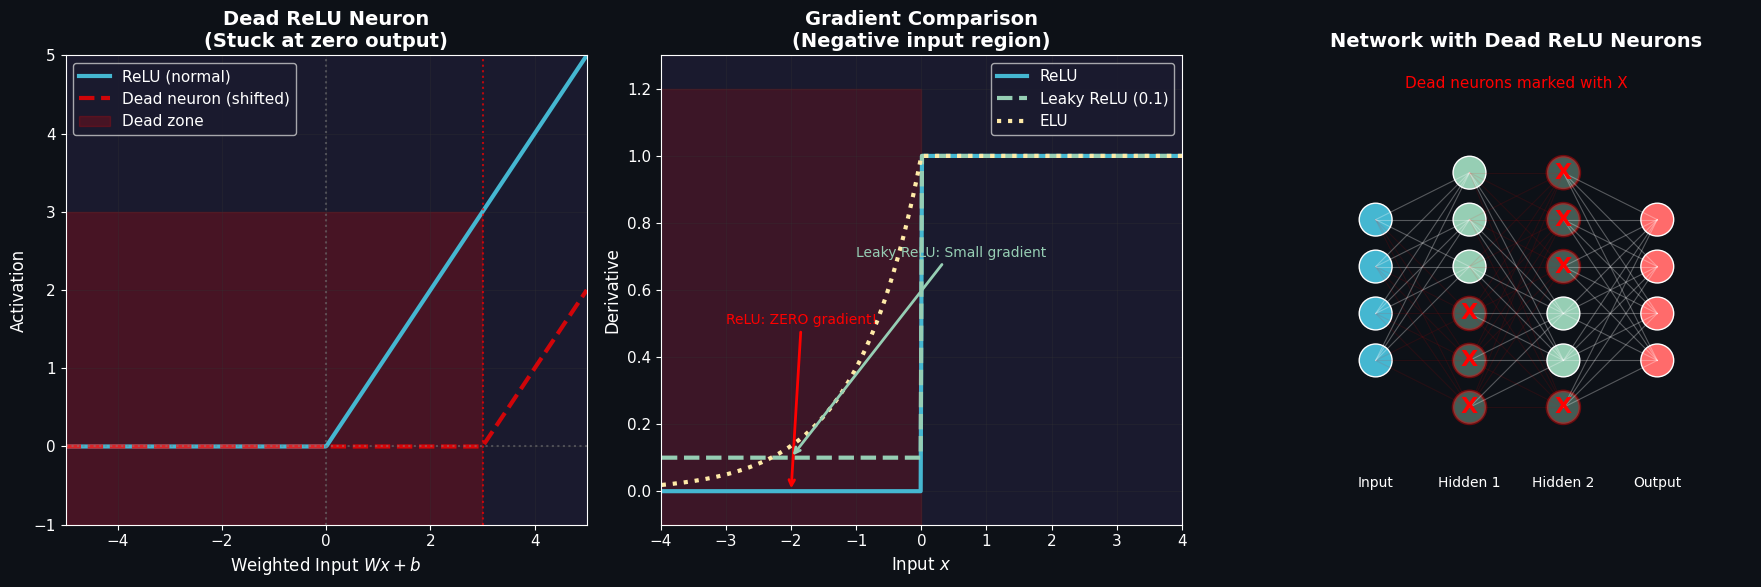


DEAD RELU PROBLEM:
   - Neurons can get stuck outputting zero
   - Zero output -> Zero gradient -> No learning
   - Up to 40% of neurons can die with poor initialization!

SOLUTIONS:
   - Use Leaky ReLU / ELU / GELU
   - Lower learning rate
   - He initialization


In [ ]:
# Visualization: Dead ReLU Problem

def visualize_dead_relu():
    fig = plt.figure(figsize=(18, 6))
    fig.patch.set_facecolor('#0d1117')

    # Subplot 1: Dead neuron illustration
    ax1 = fig.add_subplot(131)
    x = np.linspace(-5, 5, 500)

    ax1.plot(x, relu(x), color=COLORS['relu'], linewidth=3, label='ReLU (normal)')
    ax1.plot(x, relu(x - 3), color='red', linewidth=3, linestyle='--',
             label='Dead neuron (shifted)', alpha=0.8)
    ax1.fill_between(x[x < 3], -1, 3, alpha=0.2, color='red', label='Dead zone')
    ax1.axvline(x=3, color='red', linestyle=':', alpha=0.7)
    ax1.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)

    ax1.set_title('Dead ReLU Neuron\n(Stuck at zero output)', fontweight='bold')
    ax1.set_xlabel('Weighted Input $Wx + b$')
    ax1.set_ylabel('Activation')
    ax1.legend(loc='upper left')
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-1, 5)

    # Subplot 2: Gradient comparison
    ax2 = fig.add_subplot(132)

    ax2.plot(x, relu_derivative(x), color=COLORS['relu'], linewidth=3, label='ReLU')
    ax2.plot(x, leaky_relu_derivative(x, 0.1), color=COLORS['leaky_relu'], linewidth=3,
             linestyle='--', label='Leaky ReLU (0.1)')
    ax2.plot(x, elu_derivative(x), color=COLORS['elu'], linewidth=3,
             linestyle=':', label='ELU')

    ax2.fill_between(x[x < 0], -0.1, 1.2, alpha=0.15, color='red')
    ax2.annotate('ReLU: ZERO gradient!', xy=(-2, 0), xytext=(-3, 0.5),
                fontsize=10, color='red',
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax2.annotate('Leaky ReLU: Small gradient', xy=(-2, 0.1), xytext=(-1, 0.7),
                fontsize=10, color=COLORS['leaky_relu'],
                arrowprops=dict(arrowstyle='->', color=COLORS['leaky_relu'], lw=2))

    ax2.set_title('Gradient Comparison\n(Negative input region)', fontweight='bold')
    ax2.set_xlabel('Input $x$')
    ax2.set_ylabel('Derivative')
    ax2.legend(loc='upper right')
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(-0.1, 1.3)

    # Subplot 3: Network with dead neurons
    ax3 = fig.add_subplot(133)
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)

    np.random.seed(42)
    layers = [4, 6, 6, 4]
    dead_prob = [0, 0.5, 0.3, 0]
    all_positions = []

    colors_network = ['#45B7D1', '#96CEB4', '#96CEB4', '#FF6B6B']

    for layer_idx, (n_neurons, color, p_dead) in enumerate(zip(layers, colors_network, dead_prob)):
        x_pos = layer_idx * 2 + 2
        layer_positions = []

        for neuron_idx in range(n_neurons):
            y_pos = (10 - n_neurons) / 2 + neuron_idx + 0.5
            is_dead = np.random.random() < p_dead
            alpha = 0.4 if is_dead else 1.0

            circle = plt.Circle((x_pos, y_pos), 0.35,
                               color=color, alpha=alpha,
                               ec='white' if not is_dead else 'red',
                               linewidth=2 if is_dead else 1)
            ax3.add_patch(circle)

            if is_dead:
                ax3.text(x_pos, y_pos, 'X', ha='center', va='center',
                        fontsize=16, color='red', fontweight='bold')

            layer_positions.append((x_pos, y_pos, is_dead))

        all_positions.append(layer_positions)

    for layer_idx in range(len(all_positions) - 1):
        for x1, y1, dead1 in all_positions[layer_idx]:
            for x2, y2, dead2 in all_positions[layer_idx + 1]:
                alpha = 0.1 if dead2 else 0.3
                color = 'red' if dead2 else 'white'
                ax3.plot([x1, x2], [y1, y2], color=color, alpha=alpha, linewidth=0.8)

    ax3.text(2, 0.8, 'Input', ha='center', fontsize=10, color='white')
    ax3.text(4, 0.8, 'Hidden 1', ha='center', fontsize=10, color='white')
    ax3.text(6, 0.8, 'Hidden 2', ha='center', fontsize=10, color='white')
    ax3.text(8, 0.8, 'Output', ha='center', fontsize=10, color='white')
    ax3.text(5, 9.3, 'Dead neurons marked with X', ha='center', fontsize=11, color='red')

    ax3.set_title('Network with Dead ReLU Neurons', fontweight='bold')
    ax3.set_aspect('equal')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

visualize_dead_relu()

print("\nDEAD RELU PROBLEM:")
print("   - Neurons can get stuck outputting zero")
print("   - Zero output -> Zero gradient -> No learning")
print("   - Up to 40% of neurons can die with poor initialization!")
print("\nSOLUTIONS:")
print("   - Use Leaky ReLU / ELU / GELU")
print("   - Lower learning rate")
print("   - He initialization")

---

## Part 6: Gradient Flow Comparison Across Activations

Computed: Sigmoid
Computed: Tanh
Computed: ReLU
Computed: Leaky ReLU
Computed: ELU
Computed: GELU
Computed: Swish


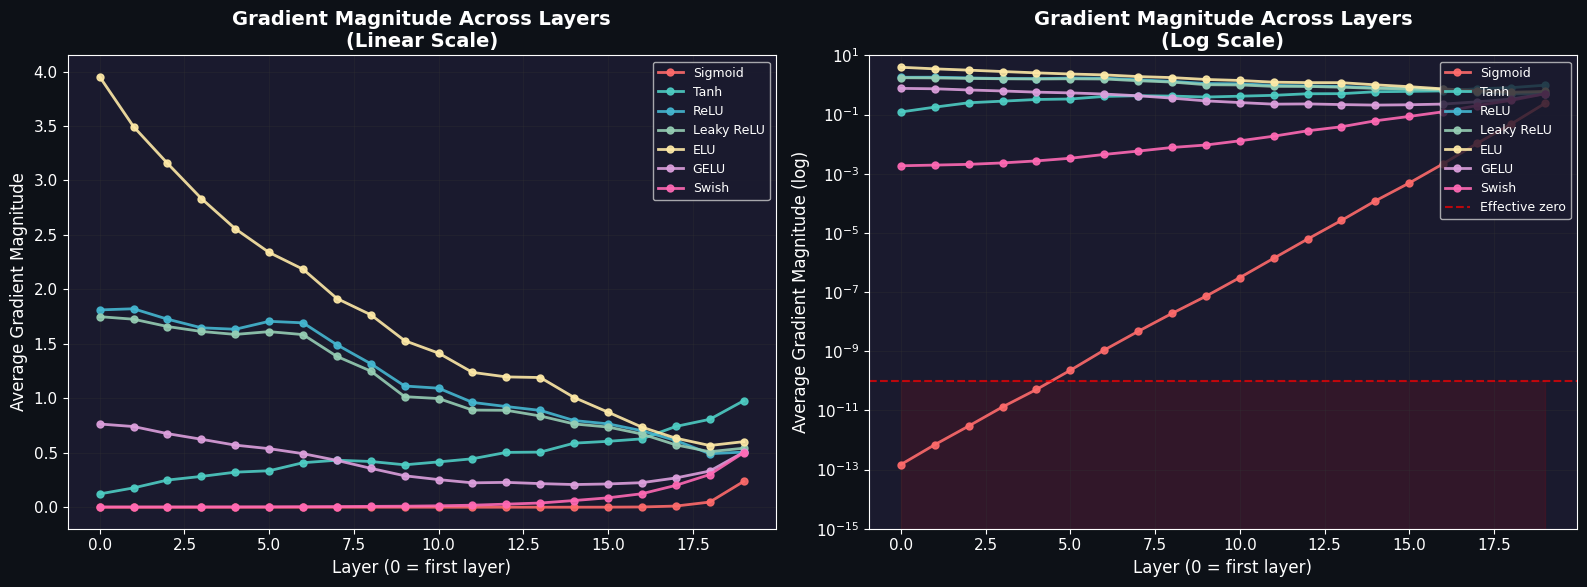


GRADIENT SUMMARY (Layer 0 / Layer 19):
Sigmoid     : 1.48e-13 / 2.36e-01 (ratio: 0x)
Tanh        : 1.22e-01 / 9.77e-01 (ratio: 0x)
ReLU        : 1.81e+00 / 5.06e-01 (ratio: 4x)
Leaky ReLU  : 1.75e+00 / 5.42e-01 (ratio: 3x)
ELU         : 3.95e+00 / 6.02e-01 (ratio: 7x)
GELU        : 7.64e-01 / 5.05e-01 (ratio: 2x)
Swish       : 1.85e-03 / 5.00e-01 (ratio: 0x)


In [ ]:
# Comprehensive gradient flow simulation

def simulate_deep_network_gradients(activation_name, n_layers=20, n_samples=500):
    """Simulate gradient flow through a deep network."""
    np.random.seed(42)

    activations = {
        'Sigmoid': (sigmoid, sigmoid_derivative),
        'Tanh': (tanh, tanh_derivative),
        'ReLU': (relu, relu_derivative),
        'Leaky ReLU': (lambda x: leaky_relu(x, 0.1), lambda x: leaky_relu_derivative(x, 0.1)),
        'ELU': (elu, elu_derivative),
        'GELU': (gelu, gelu_derivative),
        'Swish': (swish, swish_derivative),
    }

    act_fn, act_deriv = activations[activation_name]
    hidden_size = 100

    # Appropriate initialization
    if activation_name in ['ReLU', 'Leaky ReLU', 'ELU', 'GELU', 'Swish']:
        init_scale = np.sqrt(2.0 / hidden_size)  # He init
    else:
        init_scale = np.sqrt(1.0 / hidden_size)  # Xavier init

    weights = [np.random.randn(hidden_size, hidden_size) * init_scale
               for _ in range(n_layers)]

    gradient_magnitudes = []

    for _ in range(n_samples):
        x = np.random.randn(hidden_size)
        activations_list = [x]
        pre_activations = []

        for w in weights:
            z = w @ activations_list[-1]
            pre_activations.append(z)
            activations_list.append(act_fn(z))

        grad = np.ones(hidden_size)
        layer_grads = []

        for i in range(n_layers - 1, -1, -1):
            grad = grad * act_deriv(pre_activations[i])
            layer_grads.append(np.mean(np.abs(grad)))
            grad = weights[i].T @ grad

        gradient_magnitudes.append(layer_grads[::-1])

    return np.mean(gradient_magnitudes, axis=0)

# Run simulations
n_layers = 20
activation_names = ['Sigmoid', 'Tanh', 'ReLU', 'Leaky ReLU', 'ELU', 'GELU', 'Swish']
colors_list = [COLORS['sigmoid'], COLORS['tanh'], COLORS['relu'],
               COLORS['leaky_relu'], COLORS['elu'], COLORS['gelu'], COLORS['swish']]

results = {}
for name in activation_names:
    results[name] = simulate_deep_network_gradients(name, n_layers)
    print(f"Computed: {name}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor('#0d1117')

layers = np.arange(n_layers)

# Linear scale
ax1 = axes[0]
for name, color in zip(activation_names, colors_list):
    ax1.plot(layers, results[name], 'o-', color=color, linewidth=2,
             markersize=5, label=name, alpha=0.9)

ax1.set_title('Gradient Magnitude Across Layers\n(Linear Scale)', fontweight='bold')
ax1.set_xlabel('Layer (0 = first layer)')
ax1.set_ylabel('Average Gradient Magnitude')
ax1.legend(loc='upper right', fontsize=9)

# Log scale
ax2 = axes[1]
for name, color in zip(activation_names, colors_list):
    ax2.semilogy(layers, results[name] + 1e-20, 'o-', color=color, linewidth=2,
                 markersize=5, label=name, alpha=0.9)

ax2.axhline(y=1e-10, color='red', linestyle='--', alpha=0.7, label='Effective zero')
ax2.fill_between(layers, 1e-20, 1e-10, alpha=0.1, color='red')

ax2.set_title('Gradient Magnitude Across Layers\n(Log Scale)', fontweight='bold')
ax2.set_xlabel('Layer (0 = first layer)')
ax2.set_ylabel('Average Gradient Magnitude (log)')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_ylim(1e-15, 10)

plt.tight_layout()
plt.show()

print("\nGRADIENT SUMMARY (Layer 0 / Layer 19):")
print("="*55)
for name in activation_names:
    ratio = results[name][0] / (results[name][-1] + 1e-20)
    print(f"{name:12}: {results[name][0]:.2e} / {results[name][-1]:.2e} (ratio: {ratio:.0f}x)")

---

## Part 7: When to Use Which Activation Function?

### Decision Guide

| Scenario | Recommended Activation | Why? |
|----------|----------------------|------|
| **Default choice** | ReLU or Leaky ReLU | Simple, fast, works well |
| **Transformer models** | GELU | Standard for BERT/GPT |
| **EfficientNet/MobileNet** | Swish (SiLU) | Discovered by NAS |
| **RNNs/LSTMs** | Tanh (internal gates) | Historical + works well |
| **Binary classification output** | Sigmoid | Outputs probability |
| **Multi-class output** | Softmax | Probability distribution |
| **Regression output** | None (Linear) | Unbounded outputs |
| **Worried about dead neurons** | Leaky ReLU, ELU | Non-zero gradient for x<0 |

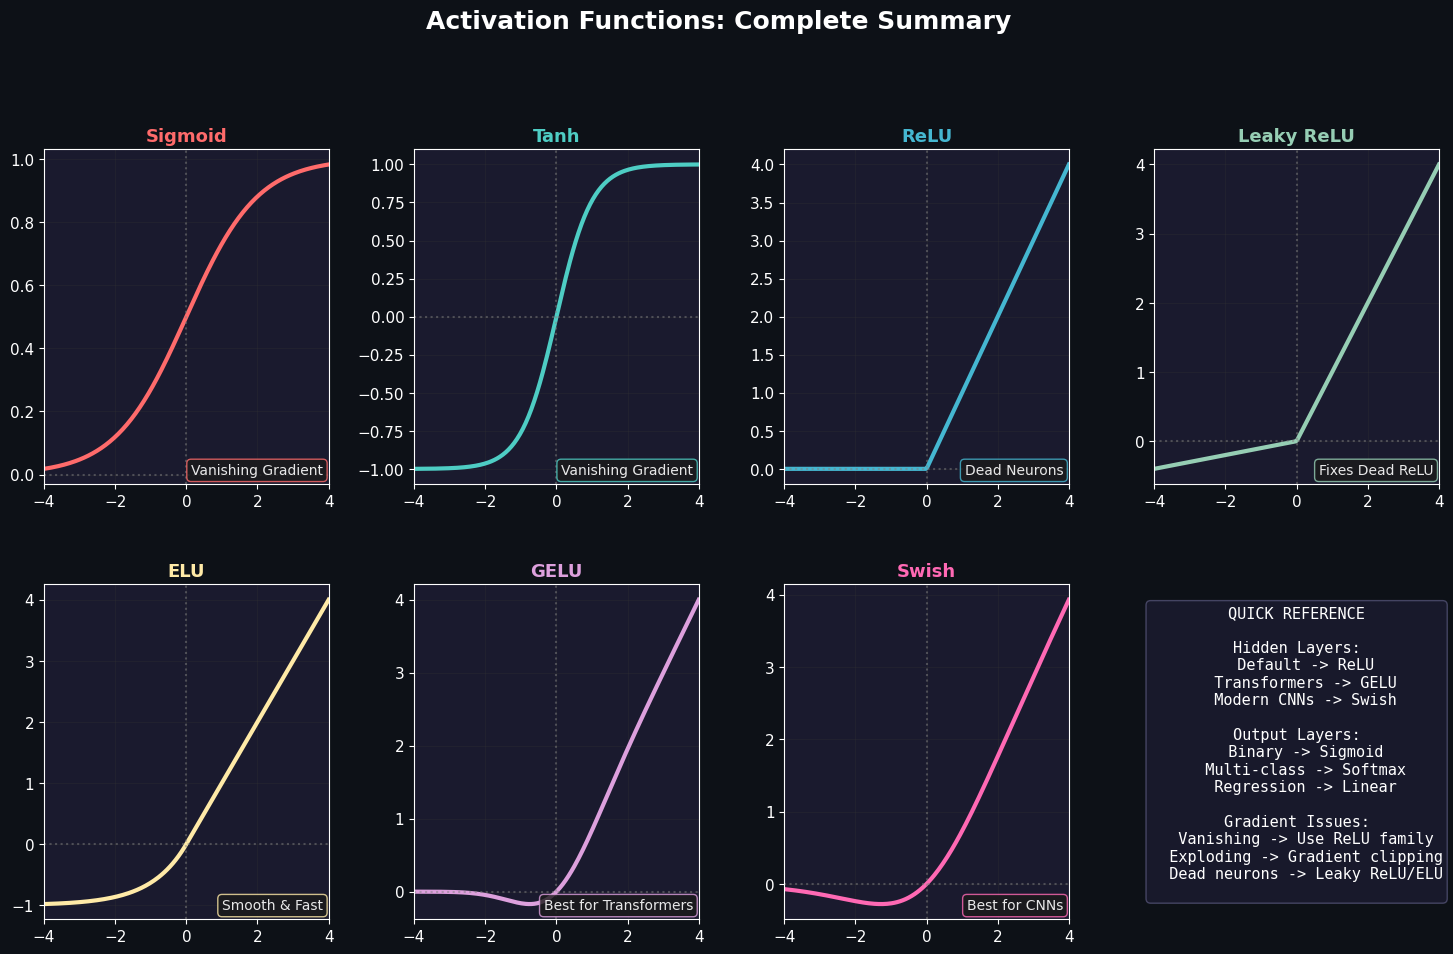


SUMMARY

What you learned:
   - Why activation functions are essential
   - The vanishing and exploding gradient problems
   - ReLU family and their properties
   - When to use which activation function


In [ ]:
# Final summary visualization

def create_summary():
    fig = plt.figure(figsize=(18, 10))
    fig.patch.set_facecolor('#0d1117')

    gs = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)
    x = np.linspace(-4, 4, 200)

    activations_final = [
        ('Sigmoid', sigmoid, COLORS['sigmoid'], 'Vanishing Gradient'),
        ('Tanh', tanh, COLORS['tanh'], 'Vanishing Gradient'),
        ('ReLU', relu, COLORS['relu'], 'Dead Neurons'),
        ('Leaky ReLU', lambda x: leaky_relu(x, 0.1), COLORS['leaky_relu'], 'Fixes Dead ReLU'),
        ('ELU', elu, COLORS['elu'], 'Smooth & Fast'),
        ('GELU', gelu, COLORS['gelu'], 'Best for Transformers'),
        ('Swish', swish, COLORS['swish'], 'Best for CNNs'),
    ]

    positions = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2)]

    for (row, col), (name, func, color, note) in zip(positions, activations_final):
        ax = fig.add_subplot(gs[row, col])
        ax.plot(x, func(x), color=color, linewidth=3)
        ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
        ax.set_title(name, fontweight='bold', fontsize=13, color=color)
        ax.set_xlim(-4, 4)
        ax.text(0.98, 0.02, note, transform=ax.transAxes, fontsize=10,
               verticalalignment='bottom', horizontalalignment='right',
               color='white', alpha=0.9,
               bbox=dict(boxstyle='round', facecolor='#1a1a1a', alpha=0.8, edgecolor=color))

    # Quick reference
    ax = fig.add_subplot(gs[1, 3])
    ax.axis('off')

    recommendations = """QUICK REFERENCE

Hidden Layers:
  Default -> ReLU
  Transformers -> GELU
  Modern CNNs -> Swish

Output Layers:
  Binary -> Sigmoid
  Multi-class -> Softmax
  Regression -> Linear

Gradient Issues:
  Vanishing -> Use ReLU family
  Exploding -> Gradient clipping
  Dead neurons -> Leaky ReLU/ELU
"""

    ax.text(0.5, 0.5, recommendations, transform=ax.transAxes, fontsize=11,
           verticalalignment='center', horizontalalignment='center',
           color='white', family='monospace',
           bbox=dict(boxstyle='round', facecolor='#1a1a2e', alpha=0.9, edgecolor='#4a4a6a'))

    plt.suptitle('Activation Functions: Complete Summary',
                fontsize=18, fontweight='bold', color='white', y=1.02)

    plt.tight_layout()
    plt.show()

create_summary()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print("\nWhat you learned:")
print("   - Why activation functions are essential")
print("   - The vanishing and exploding gradient problems")
print("   - ReLU family and their properties")
print("   - When to use which activation function")

---

## Summary

### Key Takeaways

1. **Activation functions introduce non-linearity**, allowing neural networks to learn complex patterns

2. **Vanishing gradients** (Sigmoid/Tanh):
   - Gradients shrink exponentially through layers
   - Early layers learn extremely slowly
   - Solution: ReLU family activations

3. **Exploding gradients**:
   - Gradients grow exponentially through layers
   - Causes NaN losses and unstable training
   - Solution: Gradient clipping, proper initialization

4. **ReLU revolutionized deep learning**:
   - Simple: max(0, x)
   - Fast to compute
   - Gradient = 1 when active
   - But can cause dead neurons

5. **Modern alternatives fix ReLU's issues**:
   - Leaky ReLU: Small gradient for negative inputs
   - ELU: Smooth, negative saturation
   - GELU: Probabilistic gating (Transformers)
   - Swish: Self-gated (EfficientNet)

---

## References

1. Nair & Hinton (2010): "Rectified Linear Units Improve Restricted Boltzmann Machines"
2. Clevert et al. (2016): "Fast and Accurate Deep Network Learning by ELUs"
3. Hendrycks & Gimpel (2016): "Gaussian Error Linear Units (GELUs)"
4. Ramachandran et al. (2017): "Searching for Activation Functions" (Swish)

---

**End of Notebook**